<a href="https://colab.research.google.com/github/FlorianSong/MResAMS_DataAnalytics/blob/main/Workshop1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data analytics 2022
### Workshop 1 &ndash; Introduction to Computational Statistics &ndash; 26th October 2022
##### Taught by: Nan Wu, Wilson Wu, Florian Song, Linden Schrecker, Sophia Yaliraki

Much of today's workshop was taken from https://github.com/ageron/handson-ml2/ which in turn is based on the second edition of an O'Reilly book [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) by Aurélien Geron.

### Overview & Outline


#### Topics covered today:
1. Linear regression
    * Linear regression using Normal equation
    * Linear regression using gradient descent
    * Overfitting and underfitting
    * *Extra Material: Learning curves*
    * *Extra Material: Regularised models*
        * *Ridge regression*
        * *Lasso regression*
2. Logistic regression
    * Softmax regression


Firstly, some house-keeping. We need to check if we have all the necessary libraries installed. For this we can use the following boiler plate code (piece of code that can be reused without many changes):

In [5]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action = 'ignore', message = '^internal gelsd')

# 1. Linear Regression (aka linear model)

<img src="https://raw.githubusercontent.com/rasbt/python-machine-learning-book-2nd-edition/master/code/ch01/images/01_04.png" alt="Linear Regression" align="right" width="30%"/>

* The simplest and most common form of regression
* Why *linear*?
    Response variable is a **linear function** of parameters:
    $$y_i = \beta_0 + \beta_1 x_i + \epsilon_i $$
* In the simplest case, we assume that the error $\epsilon$ has a Normal Gaussian distribution.
* This can be written in vector notation:
    $$ \boldsymbol{Y} = X\beta + \mathcal{N}(\boldsymbol{0}, \sigma^2I) = \mathcal{N}(X\beta, \sigma^2I)$$
    
### Linear regression using the Normal equation

* In the case of a simple 1D linear regression, we can find an *analytical solution* to the value of $\beta$. 
* We want to minimise the **mean squared error** (MSE):
$$ MSE(X) = \frac{1}{m}\Sigma_{i=1}^m (y_i - \boldsymbol{x_i\beta} )^2 = (Y-X\beta)^T(Y-X\beta)$$

* The analytical solution is called the **normal equation**: 
$$ \hat{\beta} = (X^TX)^{-1}X^Ty$$
* Keep in mind that for many models, we can't derive analytical solutions! In this case we need to make use of approximation methodology as we will see further below.

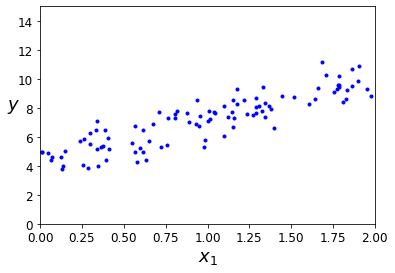

In [39]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

plt.plot(X, y, 'b.')
plt.xlabel('$x_1$', fontsize = 18)
plt.ylabel('$y$', rotation = 0, fontsize = 18)
plt.axis([0, 2, 0, 15])
plt.show()

In [40]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.33169774],
       [2.86148816]])

In [41]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.33169774],
       [10.05467406]])

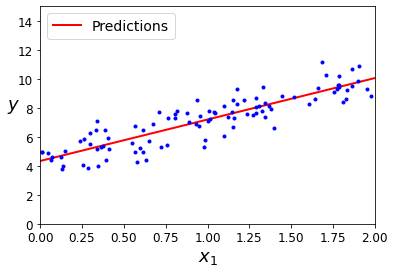

In [42]:
plt.plot(X_new, y_predict, 'r-', linewidth = 2, label = 'Predictions')
plt.plot(X, y, 'b.')
plt.xlabel('$x_1$', fontsize = 18)
plt.ylabel('$y$', rotation = 0, fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 14)
plt.axis([0, 2, 0, 15])
plt.show()

In [43]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.33169774]), array([[2.86148816]]))

##### Coefficient of determination: 

$R^2 = 1 - \frac{\color{blue}{SS_{res}}}{\color{red}{SS_{tot}}}$

<img src="https://upload.wikimedia.org/wikipedia/commons/8/86/Coefficient_of_Determination.svg" alt="" style="width:600px" align="left">


In [44]:
lin_reg.score(X, y) # Coefficient of determination, perfect value = 1

0.7852823184929572

In [45]:
lin_reg.predict(X_new)

array([[ 4.33169774],
       [10.05467406]])

<img src="https://miro.medium.com/max/1123/1*CjTBNFUEI_IokEOXJ00zKw.gif" alt="" style="width: 500px" align="right"> 

### Linear regression using gradient descent

* Gradient Descent is a generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of Gradient Descent is to tweak parameters iteratively in order to minimize a cost function.
    * Start by filling parameters with random values.
    * Then improve it gradually, taking one baby step at a time, each step attempting to decrease the cost function (e.g., the MSE), until the algorithm converges to a minimum.
* An important parameter in Gradient Descent is the size of the steps, determined by the learning rate hyperparameter.
* If the learning rate is too small, then the algorithm will have to go through many iterations to converge, which will take a long time.
* On the other hand, if the learning rate is too high, you might jump across the valley and end up on the other side, possibly even higher up than you were before.

In [46]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [47]:
theta

array([[4.33169774],
       [2.86148816]])

In [48]:
X_new_b.dot(theta)

array([[ 4.33169774],
       [10.05467406]])

In [49]:
def plot_gradient_descent(theta, eta):
    visible_steps = 20
    m = len(X_b)
    plt.plot(X, y, 'b.')
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < visible_steps:
            y_predict = X_new_b.dot(theta)
            style = '--' if iteration > 0 else '--'
            plt.plot(X_new, y_predict, style, color = cm.prism(iteration))
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients

    plt.xlabel('$x_1$', fontsize = 18)
    plt.axis([0, 2, -2, 15])
    plt.title(r'$\eta = {}$'.format(eta), fontsize = 16)

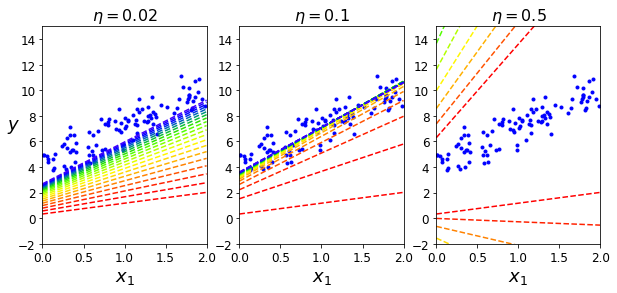

In [50]:
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize = (10,4))
plt.subplot(131); plot_gradient_descent(theta, eta = 0.02)
plt.ylabel('$y$', rotation = 0, fontsize = 18)
plt.subplot(132); plot_gradient_descent(theta, eta = 0.1)
plt.subplot(133); plot_gradient_descent(theta, eta = 0.5)

plt.show()

### Polynomial regression

* Data can be more complex than a straight line!
* E.g. where the outcome depends on higher powers of input variables: 
$$ y = \beta_0 + \beta_1 x + \beta_2 x^2 + \dots = \mathcal{N}(\phi(x)\beta, \sigma^2) $$
* $\phi(x)$ is the **link/basis function**
* Multivariate polynomial regression: Be careful with explosions of terms!

Many popular machine learning methods (e.g. SVMs, neural nets, decision trees, etc) can be seen as just different ways of estimating basis functions.

In [51]:
import numpy as np
import numpy.random as rnd

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

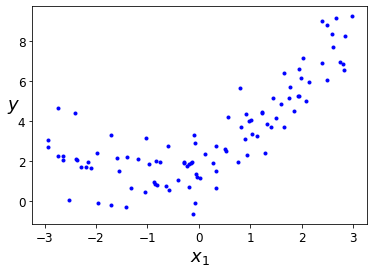

In [52]:
plt.plot(X, y, 'b.')
plt.xlabel('$x_1$', fontsize = 18)
plt.ylabel('$y$', rotation = 0, fontsize = 18)
plt.show()

In [53]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-1.7146803])

In [54]:
X_poly[0]

array([-1.7146803 ,  2.94012853])

In [55]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.89496792]), array([[1.02348053, 0.46079696]]))

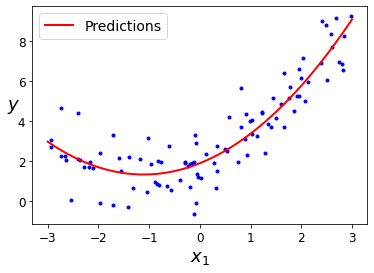

In [56]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, 'b.')
plt.plot(X_new, y_new, 'r-', linewidth = 2, label = 'Predictions')
plt.xlabel('$x_1$', fontsize = 18)
plt.ylabel('$y$', rotation = 0, fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 14)
plt.show()

### Overfitting and underfitting

* In general, the higher in degree the polynomial regression is, the better it will fit the data. 
* This is not always a good thing! 


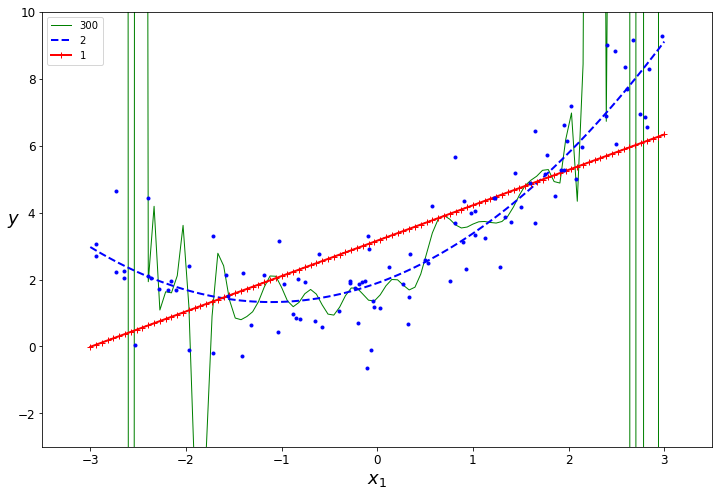

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
plt.figure(figsize = (12,8))

for style, width, degree in (('g-', 1, 300), ('b--', 2, 2), ('r-+', 2, 1)):
    polybig_features = PolynomialFeatures(degree = degree, include_bias = False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ('poly_features', polybig_features),
            ('std_scaler', std_scaler),
            ('lin_reg', lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label = str(degree), linewidth = width)

plt.plot(X, y, 'b.', linewidth = 3)
plt.legend(loc = 'upper left')
plt.xlabel('$x_1$', fontsize = 18)
plt.ylabel('$y$', rotation = 0, fontsize = 18)
plt.axis([-3.5, 3.5, -3, 10])
plt.show()

### Extra material: Learning curves

* Plots of the model’s performance on the training set and the validation set as a function of the training set size
* Train the model several times on different sized subsets of the training set 


In [65]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), 'r-+', linewidth = 2, label = 'train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth = 3, label = 'validation')
    plt.legend(loc = 'upper right', fontsize = 14)   
    plt.xlabel('Training set size', fontsize = 14)
    plt.ylabel('RMSE', fontsize = 14)             

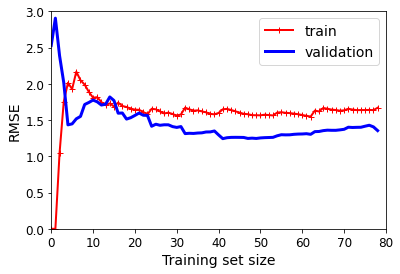

In [66]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                        
plt.show()                                     

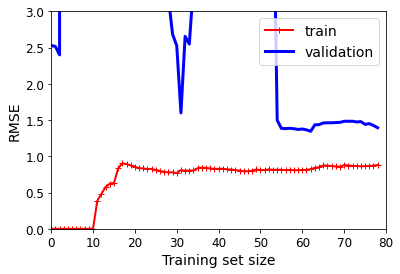

In [69]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ('poly_features', PolynomialFeatures(degree = 10, include_bias = False)),
        ('lin_reg', LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])          
plt.show()                      

### Extra material: Regularised models

* Regularising a model = constraining it: The fewer degrees of freedom, the harder to overfit
* In linear regression, this could be reducing the number of polynomial degrees.
* In the following we introduce two types: Ridge regression and Lasso Regression

##### Ridge regression

* A regularisation term equal to $\alpha \Sigma_{i=1}^n \beta_i^2 = \alpha \beta^T\beta$ is added to the cost function
* This gives a cost function:
$$ J(\beta) = MSE(\beta) + \alpha\Sigma_{i=1}^n\beta_i^2$$
* The larger $\alpha$, the flatter the predictions, i.e. a more reasonable, less exterme fit

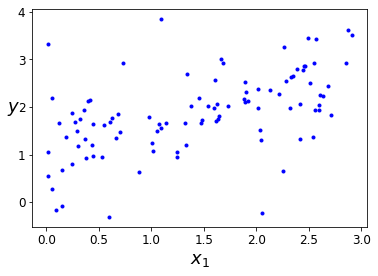

In [71]:
m = 100
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

plt.plot(X, y, 'b.')
plt.xlabel('$x_1$', fontsize = 18)
plt.ylabel('$y$', rotation = 0, fontsize = 18)
plt.show()


In [72]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 1, solver = 'cholesky', random_state = 42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.91022393]])

In [73]:
ridge_reg = Ridge(alpha = 1, solver = 'sag', random_state = 42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.9102173]])

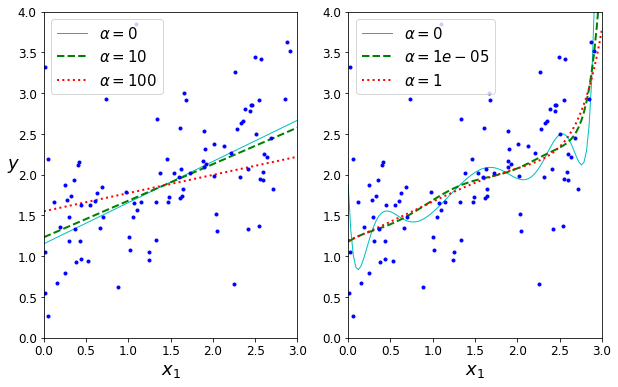

In [107]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ('c-', 'g--', 'r:')):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
                    ('std_scaler', StandardScaler()),
                    ('regul_reg', model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth = lw, label = r'$\alpha = {}$'.format(alpha))
    plt.plot(X, y, 'b.', linewidth = 3)
    plt.legend(loc = 'upper left', fontsize = 15)
    plt.xlabel('$x_1$', fontsize = 18)
    plt.axis([0, 3, 0, 4])
    
plt.figure(figsize = (10,6))
plt.subplot(121)
plot_model(Ridge, polynomial = False, alphas = (0, 10, 100), random_state = 42)
plt.ylabel('$y$', rotation = 0, fontsize = 18)
plt.subplot(122)
plot_model(Ridge, polynomial = True, alphas = (0, 10**-5, 1), random_state = 42)

plt.show()

##### Lasso Regression

* Abbreviation of *Least Absolute Shrinkage and Selection Operator Regression*
* Also adds a regularisation to the cost function, but this time it's even simpler: 
$$ J(\beta) = MSE(\beta) + \alpha \Sigma_{i=1}^n |\beta_i|$$

* Lasso regression tends to eliminate the weights of the least important features, i.e. in a way it performs *feature selection*



/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.456e+01, tolerance: 7.096e-03
  model = cd_fast.enet_coordinate_descent(


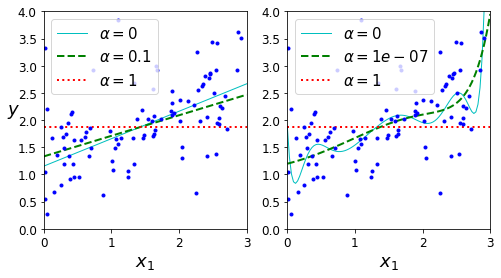

In [109]:
from sklearn.linear_model import Lasso

plt.figure(figsize = (8,4))
plt.subplot(121)
plot_model(Lasso, polynomial = False, alphas = (0, 0.1, 1), random_state = 42)
plt.ylabel('$y$', rotation = 0, fontsize = 18)
plt.subplot(122)
plot_model(Lasso, polynomial = True, alphas = (0, 10**-7, 1), random_state = 42)
plt.axis([0, 3, 0, 4])

plt.show()


In [111]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.89991459])

# 2. Logistic Regression

* Generalisation of linear regression to **binary/categorical** response variables
* Replace Gaussian with Bernoulli error:
$$ Y = Ber(\phi(x)\beta)$$
* Basis function is a **sigmoid**:
$$ \phi(x) = \frac{e^x}{1+e^x} = \frac{1}{1 + e^{-x}}$$
* Loss function: 
$$
J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}
$$
* Bad news: This has no analytical solution! :( So we have to use Gradient Descent or other optimisation algorithms.


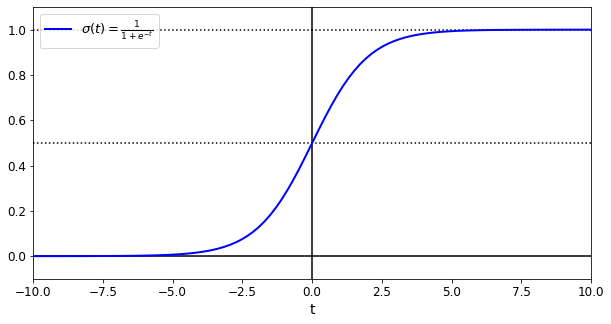

In [114]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize = (10, 5))
plt.plot([-10, 10], [0, 0], 'k-')
plt.plot([-10, 10], [0.5, 0.5], 'k:')
plt.plot([-10, 10], [1, 1], 'k:')
plt.plot([0, 0], [-1.1, 1.1], 'k-')
plt.plot(t, sig, 'b-', linewidth = 2, label = r'$\sigma(t) = \frac{1}{1 + e^{-t}}$')
plt.xlabel('t')
plt.legend(loc = 'upper left', fontsize = 13)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()


In [118]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [116]:
# print(iris.DESCR) # Uncomment this for much more information on iris

<img src="https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch01/images/01_08.png?raw=true" alt="3 different iris flowers" style="width: 40%" align="left">
<img src="https://www.embedded-robotics.com/wp-content/uploads/2022/01/Iris-Dataset-Classification.png" alt="3 different iris flowers" style="width: 55%" align="right">

In [141]:
X = (iris['data'][:, 3:]).astype(float) # petal width
y = (iris['target'] == 2).astype(int)  # 1 if Iris virginica, else 0
X

array([[0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.4],
       [0.3],
       [0.2],
       [0.2],
       [0.1],
       [0.2],
       [0.2],
       [0.1],
       [0.1],
       [0.2],
       [0.4],
       [0.4],
       [0.3],
       [0.3],
       [0.3],
       [0.2],
       [0.4],
       [0.2],
       [0.5],
       [0.2],
       [0.2],
       [0.4],
       [0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.4],
       [0.1],
       [0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.1],
       [0.2],
       [0.2],
       [0.3],
       [0.3],
       [0.2],
       [0.6],
       [0.4],
       [0.3],
       [0.2],
       [0.2],
       [0.2],
       [0.2],
       [1.4],
       [1.5],
       [1.5],
       [1.3],
       [1.5],
       [1.3],
       [1.6],
       [1. ],
       [1.3],
       [1.4],
       [1. ],
       [1.5],
       [1. ],
       [1.4],
       [1.3],
       [1.4],
       [1.5],
       [1. ],
       [1.5],
       [1.1],
       [1.8],
      

In [142]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver = 'lbfgs', random_state = 42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

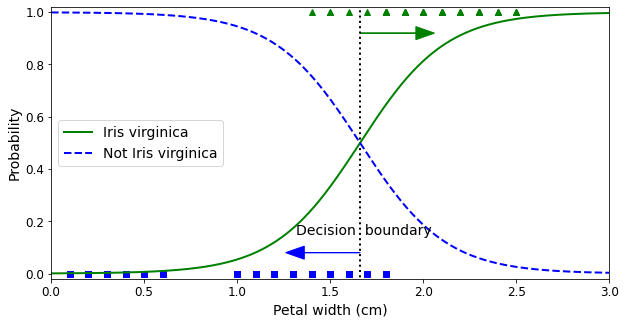

In [156]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize = (10, 5))
plt.plot(X[y == 0], y[y == 0], 'bs')
plt.plot(X[y == 1], y[y == 1], 'g^')
plt.plot([decision_boundary, decision_boundary], [-1, 2], 'k:', linewidth = 2)
plt.plot(X_new, y_proba[:, 1], 'g-', linewidth = 2, label = 'Iris virginica')
plt.plot(X_new, y_proba[:, 0], 'b--', linewidth = 2, label = 'Not Iris virginica')
plt.text(decision_boundary + 0.02, 0.15, 'Decision  boundary', fontsize = 14, color = 'k', ha = 'center')
plt.arrow(decision_boundary[0], 0.08, -0.3, 0, head_width = 0.05, head_length = 0.1, fc = 'b', ec ='b')
plt.arrow(decision_boundary[0], 0.92, 0.3, 0, head_width = 0.05, head_length = 0.1, fc = 'g', ec ='g')
plt.xlabel('Petal width (cm)', fontsize = 14)
plt.ylabel('Probability', fontsize = 14)
plt.legend(loc = 'center left', fontsize = 14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

In [157]:
decision_boundary

array([1.66066066])

In [158]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

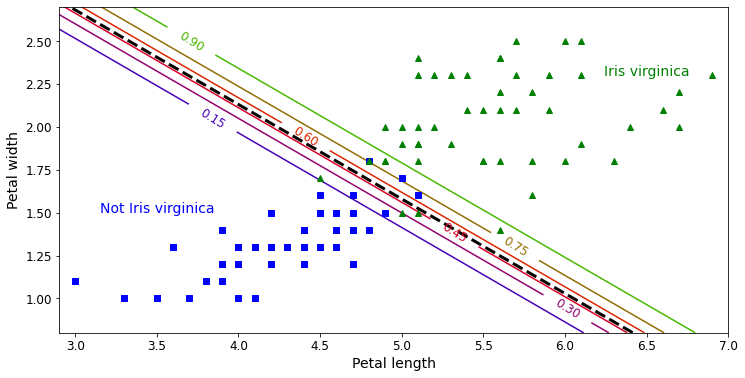

In [161]:
from sklearn.linear_model import LogisticRegression

X = iris['data'][:, (2, 3)]  # petal length, petal width
y = (iris['target'] == 2).astype(int)

log_reg = LogisticRegression(solver = 'lbfgs', C = 10**10, random_state = 42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
         np.linspace(2.9, 7, 500).reshape(-1, 1),
         np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize = (12, 6))
plt.plot(X[y == 0, 0], X[y == 0, 1], 'bs')
plt.plot(X[y == 1, 0], X[y == 1, 1], 'g^')

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap = plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline = 1, fontsize = 12)
plt.plot(left_right, boundary, 'k--', linewidth = 3)
plt.text(3.5, 1.5, 'Not Iris virginica', fontsize = 14, color = 'b', ha = 'center')
plt.text(6.5, 2.3, 'Iris virginica', fontsize = 14, color = 'g', ha = 'center')
plt.xlabel('Petal length', fontsize = 14)
plt.ylabel('Petal width', fontsize = 14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()


### Softmax Regression

* Generalisation of the logistic regression to support multiple classes
* Aka *Multinomial logistic regression*
* Simple idea: for any $x$, compute a score $s_k(x)$, then estimate the probability of each class by applying the **softmax function**
$$s_k(x) = x^T\beta^{(k)}$$
$$\hat p_k = \sigma(s(x))_k = \frac{exp(s_k(x))}{\Sigma_{j=1}^K exp(s_j(x))}$$
* $K$ is the number of classes and $\sigma(s(x))_k$ is the estimated probability that $x$ belongs to class $k$.

In [162]:
X = iris['data'][:, (2, 3)]  # petal length, petal width
y = iris['target']

softmax_reg = LogisticRegression(multi_class = 'multinomial',solver = 'lbfgs', C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

In [6]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize = (12, 6))
plt.plot(X[y == 2, 0], X[y == 2, 1], 'g^', label = 'Iris virginica')
plt.plot(X[y == 1, 0], X[y == 1, 1], 'bs', label = 'Iris versicolor')
plt.plot(X[y == 0, 0], X[y == 0, 1], 'yo', label = 'Iris setosa')

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap = custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap = plt.cm.brg)
plt.clabel(contour, inline = 1, fontsize = 12)
plt.xlabel('Petal length', fontsize = 14)
plt.ylabel('Petal width', fontsize = 14)
plt.legend(loc = 'center left', fontsize = 14)
plt.axis([0, 7, 0, 3.5])
plt.show()


NameError: name 'softmax_reg' is not defined

In [164]:
softmax_reg.predict([[5, 2]])

array([2])

In [165]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

# Take-home challenge: Regressing the periodic table

* For this exercise, we're going to use this periodic table data set from Github: https://gist.github.com/GoodmanSciences/c2dd862cd38f21b0ad36b8f96b4bf1ee. You can find the dataset in the `datasets` folder on the Github repository of this course. Alternatively, you can download this dataset manually by clicking [here](https://gist.githubusercontent.com/GoodmanSciences/c2dd862cd38f21b0ad36b8f96b4bf1ee/raw/1d92663004489a5b6926e944c1b3d9ec5c40900e/Periodic%2520Table%2520of%2520Elements.csv) and then after a right-click, using "Save as...". 
* Explore the data, what does each data field mean? Plot some of the numeric data. 
* Try a linear regression on atomic number and atomic weight. 
* More challenging: Can a Softmax regression predict the phase at room temp from the melting and boiling points? 
* Think of any other questions you may be able to answer through linear or logistic regression.


In [7]:
import csv
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from io import StringIO

try: 
    from urllib2 import urlopen
except:
    from urllib.request import urlopen

# The following bit of code tries to open the local periodic_table file, but if that fails, it grabs it from github.
try:
    periodic_table_file = open('datasets/periodic_table22.csv')
except:
    url_file = urlopen('https://gist.githubusercontent.com/GoodmanSciences/c2dd862cd38f21b0ad36b8f96b4bf1ee/raw/1d92663004489a5b6926e944c1b3d9ec5c40900e/Periodic%2520Table%2520of%2520Elements.csv')
    periodic_table_file = StringIO(url_file.read().decode('utf-8'))
    

# Set up a csv reader for the file
csv_reader = csv.reader(periodic_table_file)

# Read in the first line = header, and find out positions of relevant columns
header = next(csv_reader)
atomnum_col = header.index('AtomicNumber')
weightnum_col = header.index('AtomicMass')

In [8]:
import pandas as pd
df = pd.read_csv('/Users/nan/Desktop/Digi_Chem_22_23/datasets/periodic_table.csv')

In [9]:
df.AtomicNumber.values
df.AtomicMass.values

array([  1.007,   4.002,   6.941,   9.012,  10.811,  12.011,  14.007,
        15.999,  18.998,  20.18 ,  22.99 ,  24.305,  26.982,  28.086,
        30.974,  32.065,  35.453,  39.948,  39.098,  40.078,  44.956,
        47.867,  50.942,  51.996,  54.938,  55.845,  58.933,  58.693,
        63.546,  65.38 ,  69.723,  72.64 ,  74.922,  78.96 ,  79.904,
        83.798,  85.468,  87.62 ,  88.906,  91.224,  92.906,  95.96 ,
        98.   , 101.07 , 102.906, 106.42 , 107.868, 112.411, 114.818,
       118.71 , 121.76 , 127.6  , 126.904, 131.293, 132.905, 137.327,
       138.905, 140.116, 140.908, 144.242, 145.   , 150.36 , 151.964,
       157.25 , 158.925, 162.5  , 164.93 , 167.259, 168.934, 173.054,
       174.967, 178.49 , 180.948, 183.84 , 186.207, 190.23 , 192.217,
       195.084, 196.967, 200.59 , 204.383, 207.2  , 208.98 , 210.   ,
       210.   , 222.   , 223.   , 226.   , 227.   , 232.038, 231.036,
       238.029, 237.   , 244.   , 243.   , 247.   , 247.   , 251.   ,
       252.   , 257.

-8.604644936983988 [2.5982007]


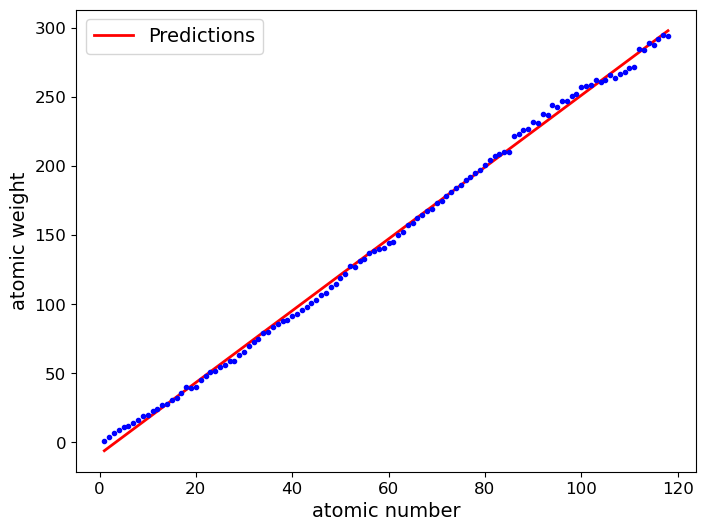

In [10]:
# Initialise X and y
X = []
y = []

# For every line in the csv file, we add atomic number to X and atomic weight to y
for line in csv_reader:
    X.append(float(line[atomnum_col]))
    y.append(float(line[weightnum_col]))

# Turn X and y in numpy arrays. Unfortunately this will cause X to become a vector rather than a 1D matrix, 
# which is what is needed for sklearn functions.
X = np.array(X).reshape(-1,1)
y = np.array(y)

# Fit a linear regression and print intercept and coefficient
lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(lin_reg.intercept_, lin_reg.coef_)

# Initialise data for plotting the regression line
X_new = np.linspace(min(X), max(X)).reshape(-1,1)
y_predict = lin_reg.predict(X_new)

# Plot the regression
plt.figure(figsize = (8, 6))
plt.plot(X_new, y_predict, 'r-', linewidth = 2, label = 'Predictions')
plt.plot(X, y, 'b.')
plt.xlabel('atomic number')
plt.ylabel('atomic weight')
plt.legend(loc = 'upper left', fontsize = 14)
plt.show()

In [11]:
# Reset the reader to the first position
periodic_table_file.seek(0)
csv_reader = csv.reader(periodic_table_file)

# Again, read in first line and find out positions of data columns
header = next(csv_reader)
phase_col = header.index('Phase')
meltpoint_col = header.index('MeltingPoint')
boilpoint_col = header.index('BoilingPoint')

# This time, we initialise two lists for each predictor vector and one outcome vector
X1 = []
X2 = []
y = []

# Fill the data lists
for line in csv_reader:
    # Using a try and except to skip ("continue") rows with non-numeric values
    try:
        meltpoint = float(line[meltpoint_col])
        boilpoint = float(line[boilpoint_col])
        
        # For softmax regression the output value needs to be numerically encoded
        # Here, we do this cleverly by using a dictionary
        phase = {'solid': 0, 
                 'liq': 1,
                 'gas':2}[line[phase_col]]
    except:
        continue
    
    X1.append(meltpoint)
    X2.append(boilpoint)
    y.append(phase)

# Convert everything to numpy arrays and concatenate X1 and X2
X1 = np.array(X1)
X2 = np.array(X2)
X = np.vstack((X1.T,X2.T)).T
y = np.array(y)

# Run a softmax regression     
softmax_reg = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', C = 10, max_iter = 300)
softmax_reg.fit(X, y)

# Try out a prediction
softmax_reg.predict([[400, 500]])

array([0])

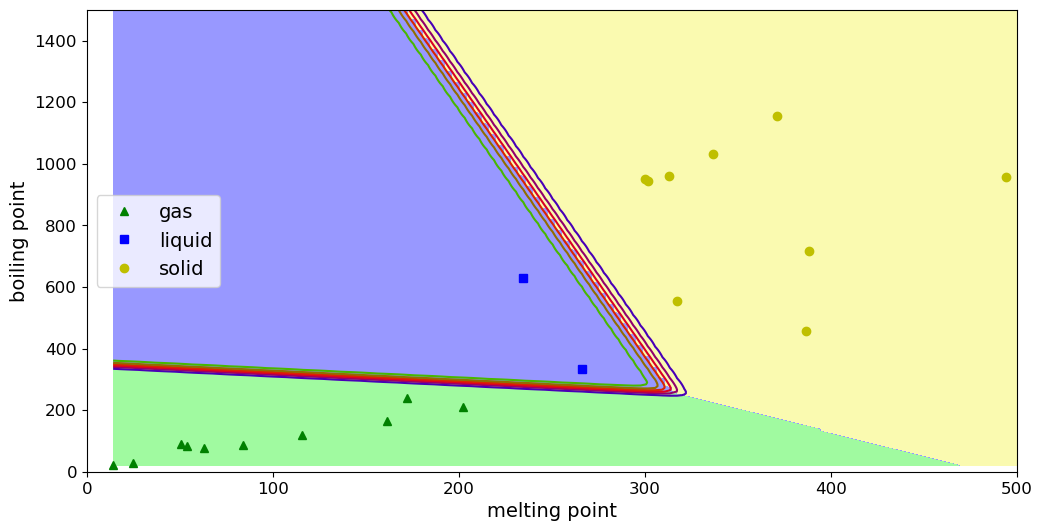

In [12]:
# Copy and paste code from code example with labels changed

x0, x1 = np.meshgrid(
        np.linspace(min(X1), max(X1), 1000).reshape(-1, 1),
        np.linspace(min(X2), max(X2), 1000).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize = (12, 6))
plt.plot(X[y == 2, 0], X[y == 2, 1], 'g^', label = 'gas')
plt.plot(X[y == 1, 0], X[y == 1, 1], 'bs', label = 'liquid')
plt.plot(X[y == 0, 0], X[y == 0, 1], 'yo', label = 'solid')

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap = custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap = plt.cm.brg)
#plt.clabel(contour, inline = 1, fontsize = 12)
plt.xlabel('melting point', fontsize = 14)
plt.ylabel('boiling point', fontsize = 14)
plt.legend(loc = 'center left', fontsize = 14)
plt.axis([0, 500, 0, 1500]) # uncomment this line to zoom into the relevant part of the data
plt.show()

In [13]:
x0, x1 = np.meshgrid(
        np.linspace(min(X1), max(X1), 1000).reshape(-1, 1),
        np.linspace(min(X2), max(X2), 1000).reshape(-1, 1),
    )

In [15]:
len(np.linspace(min(X1), max(X1), 1000))

1000

In [18]:
X_new

array([[  14.175     ,   20.28      ],
       [  18.11291291,   20.28      ],
       [  22.05082583,   20.28      ],
       ...,
       [3940.27417417, 5869.        ],
       [3944.21208709, 5869.        ],
       [3948.15      , 5869.        ]])